# Week 2 Assignment: Calculating Probability

This week's assignment is to analyse a flight dataset to determine the probability of delayed flights based on the the airport the flight originated from. 

Before analysis can begin I must follow a few housekeeping rules and prep my data. I will use the already cleaned `flights_clean.csv`, first.

__Data Prep To-Do List:__

* [x] __Load Data__
* [x] __Handle missing values__
    * [x] Document approach


__Data Analysis Questions:__

* [ ] Is the distribution of delayed flights __normally distributed__?
* [ ] What is the __shape__ of the distribution based on the __QQ-Plot__?
* [ ] What is the __probability__ a flight leaving from a given airport will arrive late to its destination ?
* [ ] What is the originating airport with the __largest/smallest proporation__ of flights arriving late to their destination?
* [ ] What is the difference between probability and proportion?
* [ ] What is the __mean and standard deviation__ of late arrival times for both of these airports?
* [ ] Based on the mean and the standard deviation information ONLY, which airport seems like the better choice?
* [ ] Comparing these two airports by their arrival delays __(histograms)__, which airport seems like you would have a better chance at arriving at your destination on time?

__Optional: *(Advanced)*__

* [ ] Clean the original flights.csv dataset using the data imputation data (Demo_Imputing_Data)
* [ ] Use the airports.csv and airlines.csv for further analysis

## Data Preparation

__Data Prep To-Do List:__

 Load Data
 Handle missing values

__I will be using the following libraries:__

- `pandas` as pd
- `numpy` as np
- `stats` from `scipy`
    - `probplot` from `scipy` for QQ-plots
    - `stats.binom.pmf()` and `stats.binom.cdf()` from `scipy`
- `resample` from `sklearn.utils`    
- `seaborn` as sns
- `matplotlib.pylab` as plt

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import scipy
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pylab as plt

In [2]:
flight_data = pd.read_csv('assign_wk2/flights_clean.csv')
flight_data.head()

,year,month,day,day_of_week,airline,flight_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,scheduled_time,elapsed_time,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled
0,2015,1,1,4,AS,98,ANC,SEA,5,2354.0,-11.0,205.0,194.0,430,408.0,-22.0,0,0
1,2015,1,1,4,AA,2336,LAX,PBI,10,2.0,-8.0,280.0,279.0,750,741.0,-9.0,0,0
2,2015,1,1,4,US,840,SFO,CLT,20,18.0,-2.0,286.0,293.0,806,811.0,5.0,0,0
3,2015,1,1,4,AA,258,LAX,MIA,20,15.0,-5.0,285.0,281.0,805,756.0,-9.0,0,0
4,2015,1,1,4,AS,135,SEA,ANC,25,24.0,-1.0,235.0,215.0,320,259.0,-21.0,0,0


In [3]:
flight_data.shape

(5245484, 18)

In [4]:
flight_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5245484 entries, 0 to 5245483
Data columns (total 18 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   year                 5245484 non-null  int64  
 1   month                5245484 non-null  int64  
 2   day                  5245484 non-null  int64  
 3   day_of_week          5245484 non-null  int64  
 4   airline              5245484 non-null  object 
 5   flight_number        5245484 non-null  int64  
 6   origin_airport       5245484 non-null  object 
 7   destination_airport  5245484 non-null  object 
 8   scheduled_departure  5245484 non-null  int64  
 9   departure_time       5245484 non-null  float64
 10  departure_delay      5245484 non-null  float64
 11  scheduled_time       5245483 non-null  float64
 12  elapsed_time         5231130 non-null  float64
 13  scheduled_arrival    5245484 non-null  int64  
 14  arrival_time         5242972 non-null  float64
 15

In [5]:
flight_data.isnull().sum()

year                       0
month                      0
day                        0
day_of_week                0
airline                    0
flight_number              0
origin_airport             0
destination_airport        0
scheduled_departure        0
departure_time             0
departure_delay            0
scheduled_time             1
elapsed_time           14354
scheduled_arrival          0
arrival_time            2512
arrival_delay              0
diverted                   0
cancelled                  0
dtype: int64

It is interesting that all of these flights were diverted. I am going to ignore that right now but note it for later in my analysis. I may go back and address that later on. I will assume:

- scheduled time is the scheduled arrival time minus the scheduled departure time
- arrival time is the scheduled arrival plus the arrival delay (negative means they arrived early)
- elapsed time is the arrival time and the departure time minus their delays in order to compare scheduled and elapsed times regarding their delay profiles

In [6]:
flight_data[flight_data.scheduled_time.isnull()]

,year,month,day,day_of_week,airline,flight_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,scheduled_time,elapsed_time,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled
1673456,2015,4,20,1,NK,174,FLL,LGA,1602,1857.0,175.0,NaN,NaN,1900,NaN,-149.05,1,0


In [7]:
def fill_missing_scheduled_time(row):
    scheduled_time = np.NaN
    
    if np.isnan(row.scheduled_time):
        scheduled_time = row.scheduled_arrival - row.scheduled_departure
    else:
        scheduled_time = row.scheduled_time
    return scheduled_time

In [8]:
flight_data.scheduled_time = flight_data.apply(lambda x: fill_missing_scheduled_time(x), axis = 1)

In [9]:
def fill_missing_arrival_time(row):
    arrival_time = np.NaN
    
    if np.isnan(row.arrival_time):
        arrival_time = row.scheduled_arrival + row.arrival_delay
    else:
        arrival_time = row.arrival_time
    return arrival_time

In [10]:
flight_data.arrival_time = flight_data.apply(lambda x: fill_missing_arrival_time(x), axis = 1)

In [11]:
def fill_missing_elapsed_time(row):
    elapsed_time = np.NaN
    
    if np.isnan(row.elapsed_time):
        elapsed_time = (row.arrival_time - row.arrival_delay) - (row.departure_time - row.departure_delay) 
    else:
        elapsed_time = row.elapsed_time
    return elapsed_time

In [12]:
flight_data.elapsed_time = flight_data.apply(lambda x: fill_missing_elapsed_time(x), axis = 1)

In [13]:
flight_data.isnull().sum()

year                   0
month                  0
day                    0
day_of_week            0
airline                0
flight_number          0
origin_airport         0
destination_airport    0
scheduled_departure    0
departure_time         0
departure_delay        0
scheduled_time         0
elapsed_time           0
scheduled_arrival      0
arrival_time           0
arrival_delay          0
diverted               0
cancelled              0
dtype: int64

I used the data available in the dataset to fill the missing values for scheduled time, arrival time, and elapsed time. 

**_If I have extra time before submitting I will go back and add in the time zones and overnight flights data._**

In [14]:
flight_data.to_csv('assign_wk2/new_flights_clean.csv',index=False)

## Data Analysis Questions:

### Is the distribution of delayed flights normally distributed?

In [2]:
sns.set()

In [3]:
delay_df = pd.read_csv('assign_wk2/new_flights_clean.csv')
delay_df

,year,month,day,day_of_week,airline,flight_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,scheduled_time,elapsed_time,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled
0,2015,1,1,4,AS,98,ANC,SEA,5,2354.0,-11.0,205.0,194.0,430,408.0,-22.0,0,0
1,2015,1,1,4,AA,2336,LAX,PBI,10,2.0,-8.0,280.0,279.0,750,741.0,-9.0,0,0
2,2015,1,1,4,US,840,SFO,CLT,20,18.0,-2.0,286.0,293.0,806,811.0,5.0,0,0
3,2015,1,1,4,AA,258,LAX,MIA,20,15.0,-5.0,285.0,281.0,805,756.0,-9.0,0,0
4,2015,1,1,4,AS,135,SEA,ANC,25,24.0,-1.0,235.0,215.0,320,259.0,-21.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5245479,2015,12,31,4,B6,688,LAX,BOS,2359,2355.0,-4.0,320.0,298.0,819,753.0,-26.0,0,0
5245480,2015,12,31,4,B6,745,JFK,PSE,2359,2355.0,-4.0,227.0,215.0,446,430.0,-16.0,0,0
5245481,2015,12,31,4,B6,1503,JFK,SJU,2359,2350.0,-9.0,221.0,222.0,440,432.0,-8.0,0,0
5245482,2015,12,31,4,B6,333,MCO,SJU,2359,2353.0,-6.0,161.0,157.0,340,330.0,-10.0,0,0


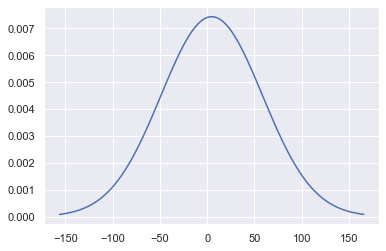

In [4]:
import scipy.stats as stats
import math

mu = delay_df.arrival_delay.mean()
variance = delay_df.arrival_delay.var()
sigma = math.sqrt(variance)
x= np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

In [5]:
delay_df['arrival_delay'].agg(['std', 'mean', 'median', 'skew'])

std       53.634236
mean       4.828597
median    -5.000000
skew      15.607266
Name: arrival_delay, dtype: float64

In [6]:
'''This indicates that there is a positive skew to the arrival delay distribution because the mean is greater than the median.'''

'This indicates that there is a positive skew to the arrival delay distribution because the mean is greater than the median.'

### What is the shape of the distribution based on the QQ-Plot?

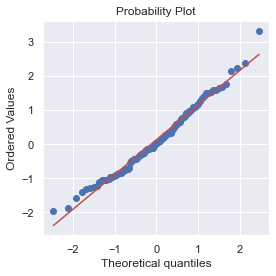

In [7]:
fig, ax = plt.subplots(figsize=(4,4))

norm_sample = stats.norm.rvs(size=100)
stats.probplot(norm_sample, plot=ax)

plt.tight_layout()
plt.show()

The blue markers above the line are the higher points of the distribution and the blue points lower and the lower points of the distribution. Those along the red line are normally distributed. 

### What is the probability a flight leaving from a given airport will arrive late to its destination?

P(A): Departure Airport

P(B): Arrival delay
(Positive delays only)

P(B|A): Arrival delay given the flight leaves a certain departed airport

P(B|A) = (P(A|B) X P(B)) / P(A)

In [8]:
def pofb(arrival_delay):
    if arrival_delay > 0:
        return 1
    else:
        return 0

delay_df['PofB'] = delay_df['arrival_delay'].apply(pofb)

In [9]:
delay_df.head()

,year,month,day,day_of_week,airline,flight_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,scheduled_time,elapsed_time,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,PofB
0,2015,1,1,4,AS,98,ANC,SEA,5,2354.0,-11.0,205.0,194.0,430,408.0,-22.0,0,0,0
1,2015,1,1,4,AA,2336,LAX,PBI,10,2.0,-8.0,280.0,279.0,750,741.0,-9.0,0,0,0
2,2015,1,1,4,US,840,SFO,CLT,20,18.0,-2.0,286.0,293.0,806,811.0,5.0,0,0,1
3,2015,1,1,4,AA,258,LAX,MIA,20,15.0,-5.0,285.0,281.0,805,756.0,-9.0,0,0,0
4,2015,1,1,4,AS,135,SEA,ANC,25,24.0,-1.0,235.0,215.0,320,259.0,-21.0,0,0,0


In [10]:
delay_df.shape

(5245484, 19)

In [11]:
delay_df.PofB.value_counts(0)

0    3297494
1    1947990
Name: PofB, dtype: int64

In [12]:
# not delayed
not_p_n = 3297494
# total
n = 5245484
# delayed
p_n = n-not_p_n
# probability of delayed flights
p_n/n

0.3713651590587256

### What is the originating airport with the largest/smallest proporation of flights arriving late to their destination?

In [31]:
delayed = delay_df['PofB'] == 1
all_delayed = delay_df.loc[delayed]
origin_airport_delays = all_delayed.origin_airport.value_counts(normalize=True)
origin_airport_delays.head()

ATL    0.059053
ORD    0.058221
DFW    0.047842
DEN    0.041515
LAX    0.040942
Name: origin_airport, dtype: float64

In [32]:
origin_airport_delays.tail()

VEL    0.000012
HYA    0.000011
DLG    0.000009
ITH    0.000007
CNY    0.000004
Name: origin_airport, dtype: float64

Largest proportion of delays are found at Atlanta Airport with a proportion of 5.9%.

Smallest proportion of delays are found at Canyonlands in Utah with an almost 0% of the proportion of delayed flights.

### What is the difference between probability and proportion?

Proportion only determines the likelihood that an event has already occured rather than the possibility of the event happening in the future.

### What is the mean and standard deviation of late arrival times for both of these airports?

In [43]:
ATL = delay_df[delay_df['origin_airport'] == 'ATL']
ATL['arrival_delay'].agg(['mean', 'std'])

mean     3.197831
std     50.764081
Name: arrival_delay, dtype: float64

In [44]:
CNY = delay_df[delay_df['origin_airport'] == 'CNY']
CNY['arrival_delay'].agg(['mean', 'std'])

mean   -20.678049
std     12.548875
Name: arrival_delay, dtype: float64

### Based on the mean and the standard deviation information ONLY, which airport seems like the better choice?

Since the average arrival time is 20 minutes earlier than scheduled for CNY is the better choice. Even with 1 standard deviation to the right of the mean the flights still arrive early rather than being delayed. Atlanta airport on average is late arriving by 3 minutes, with a standard deviation of 50. While  a flight 47 minutes early would be great, a flight almost an hour late could be more detrimental.

### Comparing these two airports by their arrival delays (histograms), which airport seems like you would have a better chance at arriving at your destination on time?

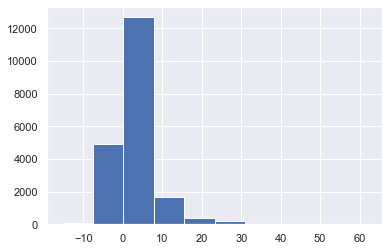

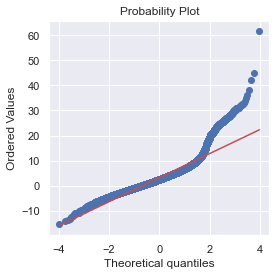

In [66]:
ATL_delay = ATL.arrival_delay.values

means = []

for _ in range(20000): 
    mean = resample(ATL_delay, replace=True, n_samples=100).mean()
    means.append(mean)
    
plt.hist(means)

fig, ax = plt.subplots(figsize=(4, 4))
stats.probplot(means, plot=ax)

plt.tight_layout()
plt.show()

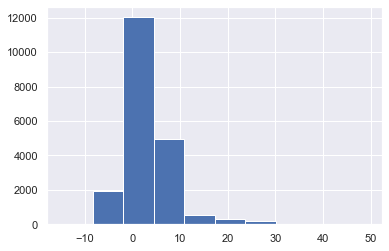

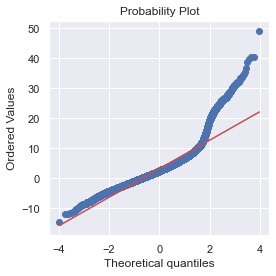

In [67]:
CNY_delay = CNY.arrival_delay.values

means = []

for _ in range(20000): 
    mean = resample(ATL_delay, replace=True, n_samples=100).mean()
    means.append(mean)
    
plt.hist(means)

fig, ax = plt.subplots(figsize=(4, 4))
stats.probplot(means, plot=ax)

plt.tight_layout()
plt.show()

These histograms say otherwise. It appears that ATL will provide greater flights that are early than those that fly out of CNY. Flights that fly out of CNY have a greater distribution on the right side of the mean than in ATL which displays that there are a greater amount of delayed arrivals form CNY than ATL.